# Sound localisation with surrogate gradient descent

In this notebook, we're going to use surrogate gradient descent to find a solution to the sound localisation problem we solved by hand in the previous notebook. The surrogate gradient descent approach and code is heavily inspired by (certainly not stolen) from [Friedemann Zenke's SPyTorch tutorial](https://github.com/fzenke/spytorch), which I recommend for a deeper dive into the maths.

## To setup before you start
First, download a copy of this notebook to your personal google drive:
1. mount your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Save a copy of the notebook to your drive: "Files" => "Save a copy in Drive"
3. Locate where this copy was saved in your dirve: "Files" => "Locate in Drive"
4. Now you can rename the located file and move it to a location of your choice in your google drive


Optional setup:  
The commands `load_ext autoreload` and `autoreload 2` are used in Jupyter notebooks to set up an automatic reloading of modules before executing a new line of code. This is particularly useful when you are editing external Python files and want those changes to be reflected in the notebook without restarting the kernel.

In [ ]:
%load_ext autoreload
%autoreload 2

## Let's start to run the notebook step-by-step

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

my_computer_is_slow = True # set this to True if using Colab

import pdb
import pandas as pd

NOTE: PyTorch is an open-source machine learning library primarily developed by Facebook's AI Research lab (FAIR).
PyTorch offers a high-level neural network module called torch.nn for building and training neural networks. It includes various layers, loss functions, and optimization algorithms.

### Creating sound stimulus and encoding spikes in auditory nerve fibers (= input data)

The following function creates a set of stimuli that can be used for training or testing. We have two ears (0 and 1), and ear 1 will get a version of the signal delayed by an IPD we can write as $\alpha$ in equations (``ipd`` in code). The basic signal is a sine wave as in the previous notebook, made positive, so $(1/2)(1+\sin(\theta)$. In addition, for each ear there will be $N_a$ neurons per ear (``anf_per_ear`` because these are auditory nerve fibres). Each neuron generates Poisson spikes at a certain firing rate, and these Poisson spike trains are independent. In addition, since it is hard to train delays, we seed it with uniformly distributed delays from a minimum of 0 to a maximum of $\pi/2$ in each ear, so that the differences between the two ears can cover the range of possible IPDs ($-\pi/2$ to $\pi/2$). We do this directly by adding a phase delay to each neuron. So for ear $i\in\{0,1\}$ and neuron $j$ at time $t$ the angle $\theta=2\pi f t+i\alpha+j\pi/2N_a$. Finally, we generate Poisson spike trains with a rate $R_\mathrm{max}((1/2)(1+\sin(\theta)))^k$. $R_\mathrm{max}$ (``rate_max``) is the maximum instantaneous firing rate, and $k$ (``envelope_power``) is a constant that sharpens the envelope. The higher $R_\mathrm{max}$ and $k$ the easier the problem (try it out on the cell below to see why).

Here's a picture of the architecture for the stimuli:

![Stimuli architecture](https://github.com/neural-reckoning/cosyne-tutorial-2022/blob/main/arch-stimuli.png?raw=1)

The functions below return two arrays ``ipd`` and ``spikes``. ``ipd`` is an array of length ``num_samples`` that gives the true IPD, and ``spikes`` is an array of 0 (no spike) and 1 (spike) of shape ``(num_samples, duration_steps, 2*anf_per_ear)``, where ``duration_steps`` is the number of time steps there are in the stimulus.

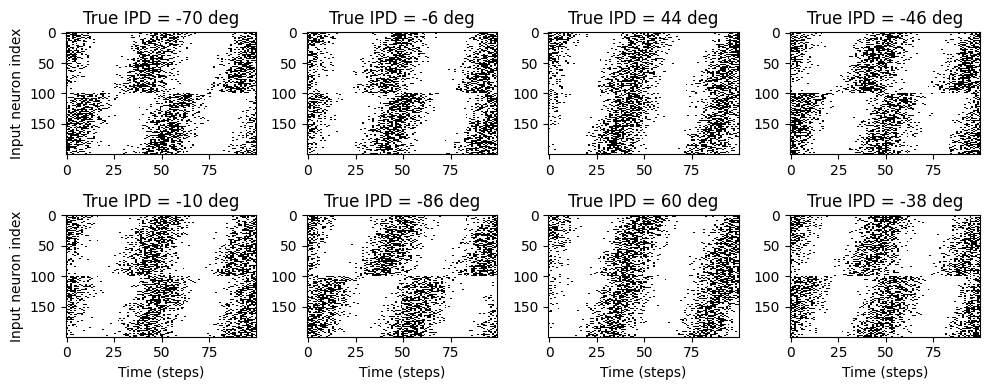

In [ ]:
# We use the following constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

# Stimulus and simulation parameters
dt = 1*ms            # large time step to make simulations run faster for tutorial
anf_per_ear = 100    # number of auditory nerve fibers connected to each ear with independent noise
envelope_power = 2   # higher values make sharper envelopes. Easier by eye => But does the network perform better ?
rate_max = 600*Hz    # maximum Poisson firing rate
f = 20*Hz            # stimulus frequency
duration = .1*second # stimulus duration
duration_steps = int(np.round(duration/dt))  # number of simulation steps
input_size = 2*anf_per_ear

# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd):
    """
  Generate a Poisson spike train based on an input Interaural Phase Difference (IPD) array
  and the delays imposed by the individual auditory nerve fibers.

    Parameters
    ----------
    ipd : array-like
        An array of true Interaural Phase Differences (IPD). Shape: (num_samples, )

    Returns
    -------
    spikes : ndarray
        A binary array indicating spike occurrences, shaped (num_samples, duration_steps, 2*anf_per_ear).
        `spikes[i, j, k]` is 1 if a spike occurred at the jth time step for the ith IPD in the kth auditory nerve fiber,
        and 0 otherwise.

    Notes
    -----
    - The function first calculates an array of phases (`phi`) to define the sinudoidal auditory stimulus and adds a random
    phase offset because we want that the system learns to infer the angular location of the sound source indepent of its distance
    to the source.
    - An array of theta values is initialized that will hold the transformed phi values according to the phase delay  imposed by the
    individual auditory nerve fibers and the ipd between the two ears.
    - Different phase delays, ranging from 0 to pi/2, are calculated and added with the ipd value to generate theta.
    - Poisson spikes are generated based on the theta values and a sinusoidal modulation of the firing rate.
    - The spikes are returned as a binary array, indicating the occurrence of spikes across auditory nerve fibers and time.
  """
    num_samples = len(ipd) # corresponds to the number of different locations of the source in the data set

    T = np.arange(duration_steps)*dt # array of times over which the auditory signal is constructed
    phi = 2*np.pi*(f*T) + 2*np.pi*np.random.rand() # array of phases corresponding to those times with random offset
    # because we want that the system learns to infer the angular location of the sound source indepent of its distance
    # to the source. The phase in this array increases linearly.

    phase_delays = np.linspace(0, np.pi/2, anf_per_ear) # array of phase delays introduced by the auditory nerve fibers.
    # For each ear, we have anf_per_ear different phase delays from 0 to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2

    theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear)) # 3D array that holds the spike pattern of all auditory nerve fibers for all the interaural phase difference in the data set.
    # num_samples = number of different IPD values in our data set
    # duration_step = number of time points in our auditory signal
    # 2*anf_per_ear = total number of auditory nerve fibers

    # Now we set up these theta values. Some numpy vectorisation logic using broadcasting to implements the idea in the text above.
    theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]

    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power > np.random.rand(num_samples, duration_steps, 2*anf_per_ear)
    return spikes

# Generate some true IPDs from (-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, tensor=True):
    """
    Generate random Interaural Phase Differences (IPDs) and then corresponding spike arrays using
    the function input_signal(idp).

      The function generates `num_samples` IPDs, uniformly distributed in the range (-pi/2, pi/2).
      It then generates corresponding spike arrays using the `input_signal` function.
      Optionally, IPDs and spike arrays can be converted to PyTorch tensors.

      Parameters
      ----------
      num_samples : int
          The number of IPD samples to generate.
      tensor : bool, optional
          If True, converts the IPDs and spike arrays to PyTorch tensors before returning them.
          If False, they are returned as NumPy arrays. Default is True.

      Returns
      -------
      ipd : ndarray or Tensor
          An array of randomly generated IPDs. Shape: (num_samples, ).
          Returned as a PyTorch tensor if `tensor` is True, otherwise as a NumPy array.
      spikes : ndarray or Tensor
          A binary array indicating spike occurrences along time, generated by `input_signal` based on `ipd`.
          Returned as a PyTorch tensor if `tensor` is True, otherwise as a NumPy array.
          Shaped: (num_samples, duration_steps, 2*anf_per_ear)

      Notes
      -----
      - Ensure that the `input_signal` function is defined in your environment as it is called within this function.
      - If `tensor` is True, ensure that PyTorch is installed and configured in your environment.

      Examples
      --------
      >>> ipd, spikes = random_ipd_input_signal(50, tensor=False)
      >>> print(ipd.shape, spikes.shape)
      (50,) (50, duration_steps, 2*anf_per_ear)
  """
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes

# Plot for a few true IPDs the generated spike trains of the auditory nerve fibers to show how it looks.
# The first 100 lines are auditory nerve fiber responses of the righ ear and the others are from the left ear.
# You note that the IPDs was applied to the left ear's fibers.
ipd, spikes = random_ipd_input_signal(8)
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Input neuron index')
plt.tight_layout()

### Classification approach

Now the aim is to take these input spikes and infer the IPD. We can do this either by discretising and using a classification approach, or with a regression approach. For the moment, let's try it with a classification approach.

We discretise the IPD range of $[-\pi/2, \pi/2]$ into $N_c$ (``num_classes``) equal width segments. Replace angle $\phi$ with the integer part (floor) of $(\phi+\pi/2)N_c/\pi$. We also convert the arrays into PyTorch tensors for later use. The algorithm will now guess the index $i$ of the segment, converting that to the midpoint of the segment $\phi_i=a+(i+1/2)(b-a)/N_c$ when needed.

The algorithm will work by outputting a length $N_c$ vector $y$ and the index of the maximum value of y will be the guess as to the class (1-hot encoding), i.e. $i_\mathrm{est}=\mathrm{argmax}_i y_i$. We will perform the training with a softmax and negative loss likelihood loss, which is a standard approach in machine learning, especially in the context of multi-class classification tasks.






#### Note on the use of the softmax function:
Probability Distribution: The softmax function transforms the output of a neural network's final layer into a probability distribution over multiple classes. This is important because it ensures that the predicted values for each class sum up to 1.0. This probability distribution allows us to interpret the network's output as the likelihood of each class being the correct class.

Differentiability: The softmax function is differentiable, which makes it suitable for training neural networks using gradient-based optimization techniques, such as gradient descent. The gradients of the softmax function can be efficiently computed during backpropagation, enabling the network to learn and update its parameters.

Cross-Entropy Loss: In conjunction with the softmax function, the cross-entropy loss (also known as log loss) is often used as the loss function for training neural networks. The cross-entropy loss measures the dissimilarity between the predicted probabilities and the true class labels. It encourages the network to assign high probabilities to the correct class and low probabilities to other classes, effectively optimizing the model's predictions for classification tasks.

Multi-Class Classification: For multi-class classification problems, where an input can belong to one of several classes, the softmax function provides a natural way to model and predict class probabilities. It helps in making decisions about which class an input most likely belongs to.

Interpretability: The softmax function's output can be interpreted as class probabilities, which is valuable not only for making predictions but also for understanding the model's confidence in those predictions. This can be useful for post-processing or decision-making based on the network's output probabilities.

In [ ]:
# classes at 15 degree increments
num_classes = 180//15
print(f'Number of classes = {num_classes}')

def discretise(ipds):
    """
      Discretize Interaural Phase Differences (IPDs) to generate class labels.

      The function maps IPDs, which are continuous values in the range (-pi/2, pi/2),
      to discrete classes in the range [0, num_classes-1]. The resulting discrete values
      are suitable for classification tasks.

        Parameters
        ----------
        ipds : Tensor
            A tensor containing continuous IPD values. The values should be in the range (-pi/2, pi/2).

        Returns
        -------
        Tensor
            A tensor containing the classification of IPD values, in the range [0, num_classes-1].

        Notes
        -----
        - Assumes the input `ipds` is a PyTorch tensor.
        - `num_classes` should be defined in the surrounding scope.
        - The output tensor will have the same shape as the input `ipds`.

        Examples
        --------
        >>> ipds = torch.tensor([-np.pi/2, 0, np.pi/2])
        >>> ipd_indices = discretise(ipds)
    """
    return ((ipds+np.pi/2)*num_classes/np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    """
      This function maps IPD indices, which are discrete values in the range [0, num_classes-1],
      back to continuous IPD values. The resulting continuous values are suitable for
      representing the midpoints of the original IPD ranges in the continuous domain.

        Parameters
        ----------
        ipd_indices : array-like
            An array or tensor of IPD indices, which are discrete values obtained from
            discretizing continuous IPDs into `num_classes` bins by the function discretise(ipds).

        Returns
        -------
        array-like
            An array or tensor of continuous IPD midpoints, corresponding to the provided
            `ipd_indices`. The midpoints are computed based on the assumed discretization
            strategy, and are in the range (-pi/2, pi/2).

        Notes
        -----
        - `num_classes` should be defined in the surrounding scope and should be the same
          value that was used for discretization.
        - The input `ipd_indices` and the output will have the same shape.
        - The output type (e.g., NumPy array, PyTorch tensor) will match the input type.
    """
    return (ipd_indices+0.5)/num_classes*np.pi-np.pi/2

Number of classes = 12


### Set training parameters:

In [ ]:
# Parameters for training. These aren't optimal, but instead designed
# to give a reasonable result in a small amount of time for the tutorial!
if my_computer_is_slow:
    batch_size = 64
    n_training_batches = 64
else:
    batch_size = 128
    n_training_batches = 128
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# NOTE 1:A batch is a subset of the training dataset used for a single update of the model parameters.
# Rather than updating model parameters after processing each individual data point (stochastic gradient descent),
# batches allow the network to update parameters after processing a group of data points.
# This approach is called mini-batch gradient descent and is more computationally efficient than stochastic gradient descent.
# The size of a batch, known as the batch size, is an important hyperparameter and can affect
# the model's training dynamics and performance.

# NOTE2 : Small batch sizes improve generalization through noisier gradients and
# require less memory, making them ideal for limited resources, but they may
# lead to slower computation and less stable convergence due to noisier gradient
# updates. Conversely, large batch sizes enhance computational efficiency and stability
# of gradient estimates due to better GPU utilization, but they demand more memory and
# might result in poorer generalization due to the risk of converging to sharp minima
# that don't generalize well on unseen data.



# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    """
    Generate batches of data, iterating over IPDs and spikes in a randomized order.

    This generator function yields shuffled batches of interaural phase differences (IPDs) and spikes,
    facilitating mini-batch gradient descent training of a model. The order of the data is randomized
    to improve learning, mitigating the risk of the model memorizing the order of the training data
    (overfitting) and helping the model generalize better to unseen data.

      Parameters
      ----------
      ipds : Tensor
          A 1D tensor of IPD values.
          Shape: (n_samples, )
      spikes : Tensor
          A 3D tensor representing a batch of input spike trains.
          Shape: (n_samples, duration_steps, input_size)

      Yields
      ------
      spike_batch : Tensor
          A 3D tensor containing a batch of input spike trains.
          Shape: (batch_size, duration_steps, input_size)
      ipd_batch : Tensor
          A 1D tensor containing a batch of IPD values.
          Shape: (batch_size, )

      Notes
      -----
      - `batch_size` should be defined in the surrounding scope or passed as an argument.
      - Ensure that `ipds` and the first dimension of `spikes` have the same size.
      - The generator yields `spike_batch` and `ipd_batch` which are randomly shuffled batches of `spikes` and `ipds` respectively.
    """
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        spike_batch = spikes[i*batch_size:(i+1)*batch_size, :, :]  # spike_batch
        ipd_batch   = ipds[i*batch_size:(i+1)*batch_size]          # ipd_batch
        yield spike_batch, ipd_batch               # yield means that at each function call the function returns the next result of the loop interation

### Construct the Spiking model

Next we'll implement a version of the model with spikes to see how that changes performance. We'll just add a single hidden feed-forward layer of spiking neurons between the input and the output layers. This layer will be spiking, so we need to use the surrogate gradient descent approach.

![Full architecture](https://github.com/neural-reckoning/cosyne-tutorial-2022/blob/main/arch-full.png?raw=1)

#### Surrogate gradient descent

First, this is the key part of surrogate gradient descent, a function where we override the computation of the gradient to replace it with a smoothed gradient. You can see that in the forward pass (method ``forward``) it returns the Heaviside function of the input (takes value 1 if the input is ``>0``) or value 0 otherwise. In the backwards pass, it returns the gradient of a sigmoid function.

In [ ]:
beta = 5

class SurrGradSpike(torch.autograd.Function):
    """
      This class allows for the approximation of gradients for non-differentiable spiking functions, enabling
      the backpropagation of errors in networks that incorporate spiking neurons. The forward method applies
      a thresholding logic, mimicking the firing of a neuron, while the backward method implements the surrogate
      gradient calculation.

      Methods
      -------
      @staticmethod
      forward(ctx, input):
          Computes the forward propagation step in the neural network. This method applies a specific logic to
          mimic the all-or-none spiking nature of biological neurons. It generates a binary output corresponding
          to whether each neuron in the input tensor has fired or not.
          Parameters:
              ctx : torch.autograd.function._ContextMethodMixin
                  A context object for storing information necessary for the backward computation.
              input : torch.Tensor
                  A tensor containing the input data, typically the neuronal activations in form of the membrane potential,
                  for which the output firing response will be computed.
          Returns:
              torch.Tensor: A tensor with the same shape as input, filled with binary values indicating whether
              each neuron has fired (1.0) or not (0.0).

      @staticmethod
      backward(ctx, grad_output):
          Computes the backward propagation step in the neural network. This method calculates the surrogate
          gradients of the loss function with respect to the input activations. It is designed to work with
          the non-differentiable nature of spiking neurons by approximating the gradients.
          Parameters:
              ctx : torch.autograd.function._ContextMethodMixin
                  A context object that has the information stashed during the forward pass.
              grad_output : torch.Tensor
                  A tensor containing the gradient of the loss function with respect to the outputs of the forward method.
          Returns:
              torch.Tensor: A tensor containing the surrogate gradients of the loss function with respect to
              the input activations, which can be backpropagated through the rest of the network.
      """
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        # grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        return grad

spike_fn  = SurrGradSpike.apply   # allows the defined class to be used as a function.

#### Creat network architecture and update function

The code for the updated model is very similar to the membrane only layer. First, for initialisation we now need two weight matrices, $W_1$ from the input to the hidden layer, and $W_2$ from the hidden layer to the output layer. Second, we run two passes of the loop that you saw above for the membrane only model.

The first pass computes the output spikes of the hidden layer. The second pass computes the output layer and is exactly the same as before except using the spikes from the hidden layer instead of the input layer.

For the first pass, we modify the function in two ways.

Firstly, we compute the spikes with the line ``s = spike_fn(v-1)``. In the forward pass this just computes the Heaviside function of $v-1$, i.e. returns 1 if $v>1$, otherwise 0, which is the spike threshold function for the LIF neuron. In the backwards pass, it returns a gradient of the smoothed version of the Heaviside function.

The other line we change is the membrane potential update line. Now, we multiply by $1-s$ where ($s=1$ if there was a spike in the previous time step, otherwise $s=0$), so that the membrane potential is reset to 0 after a spike (but in a differentiable way rather than just setting it to 0).

In [ ]:
num_hidden = 30

# Weights and uniform weight initialisation
def init_weight_matrices():
    # Input to hidden layer
    W1 = nn.Parameter(torch.empty((input_size, num_hidden), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W1, -bound, bound)
    # Hidden layer to output
    W2 = nn.Parameter(torch.empty((num_hidden, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W2, -bound, bound)
    return W1, W2

# Run the simulation
def snn(input_spikes, W1, W2, tau=20*ms):
    # First layer: input to hidden
    v = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, W1))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    # Second layer: hidden to output
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        # v = alpha * v + torch.where(h[:, t, :] > 0, h[:, t, :], torch.zeros_like(h[:, t, :]))   # VB  allow only positive inputs to change the membrane pot.
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)
    # Return recorded membrane potential of output
    return v_rec

### Define function to analyse the simulation results

This function computes the training and test accuracy, and plots histograms and confusion matrices to understand the errors it's making.

In [ ]:
def analyse(ipds, spikes, label, run, plot_analysis):
    """
    Analyse the performance of a classifier on interaural phase difference (IPD) data.

    This function evaluates the accuracy and error of a classifier by comparing its
    output with true IPD values. It computes the mean and standard deviation of the
    classifier's accuracy and the absolute error in degrees. Additionally, it can
    generate histograms and a confusion matrix to visualize the results.

    Parameters:
    ipds (array): Array of true IPD values.
    spikes (array): Array of spike data corresponding to the IPDs.
    label (str): Label for the data, used in plot titles.
    run (callable): Function that runs the classifier on a batch of spike data.
    plot_analysis (bool): If True, plot histograms and confusion matrix.

    Returns:
    tuple: Tuple containing mean and standard deviation of classifier accuracy,
           and mean and standard deviation of absolute error in degrees.
    """
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((num_classes, num_classes))
    for spike_batch, ipd_batch in data_generator(ipds, spikes): #Generate batches of data, iterating over IPDs and spikes in a randomized order.
        ipd_batch_orig = ipd_batch
        ipd_batch = discretise(ipd_batch)
        # run network
        output = run(spike_batch)
        m = torch.sum(output, 1)  # agregration function: here Sum over time dimension
        _, am = torch.max(m, 1)   # argmax over output units to select the classe with the highest score in the output

        # construct confusion matrix
        for i, j in zip(ipd_batch.detach().cpu().numpy(), am.detach().cpu().numpy()):  # update the confusion matrix
            confusion[j, i] += 1
        ipd_true.append(ipd_batch_orig) # creates a list of arrays
        ipd_est.append(continuise(am.detach().cpu().numpy()))

        # calculate accuracy
        tmp = np.mean((ipd_batch == am).detach().cpu().numpy())  # compare to labels
        accs.append(tmp)
    ipd_true = np.hstack(ipd_true) # connetecates the arrays in the list horizontally to create a single flattened array
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi

    classifier_accuracy_mean = 100*np.mean(accs) # in percent
    classifier_accuracy_std = 100*np.std(accs) # in percent
    absolute_error_mean = np.mean(abs_errors_deg) # in degree
    absolute_error_std = np.std(abs_errors_deg) # in degree

    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    if plot_analysis:
      plt.figure(figsize=(10, 4), dpi=100)
      plt.subplot(121)
      plt.hist(ipd_true*180/np.pi, bins=num_classes, label='True')
      plt.hist(ipd_est*180/np.pi, bins=num_classes, label='Estimated')
      plt.xlabel("IPD")
      plt.yticks([])
      plt.legend(loc='best')
      plt.title(label)
      plt.subplot(122)
      confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
      plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
      plt.xlabel('True IPD')
      plt.ylabel('Estimated IPD')
      plt.title('Confusion matrix')
      plt.tight_layout()

    return classifier_accuracy_mean, classifier_accuracy_std, absolute_error_mean, absolute_error_std


### Do the Training and the Analysing

We train it as before, except that we modify the functions to take the two weight matrices into account.

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.17257
Epoch 2: loss=1.38754
Epoch 3: loss=1.10757
Epoch 4: loss=0.96420
Epoch 5: loss=0.84949
Epoch 6: loss=0.74436
Epoch 7: loss=0.73615
Epoch 8: loss=0.64543
Epoch 9: loss=0.64422
Epoch 10: loss=0.57507


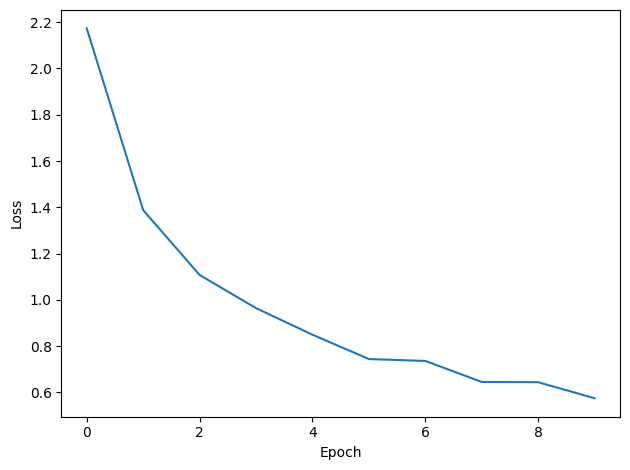

In [ ]:
# TRAINING

# Training parameters
nb_epochs = 10 # is quick, it won't have converged.
# Note: An epoch is one complete pass through the entire training dataset.
# During an epoch, the neural network processes every example in the dataset once.
# Completing an epoch means that every data point has been used for calculating the loss and updating the model parameters.
# Multiple epochs are usually required for the network to converge to an optimal set of parameters.
lr = 0.01 # learning rate

# Generate the training data
ipds, spikes = random_ipd_input_signal(num_samples)

# Initialise a weight matrices
W1, W2 = init_weight_matrices()

# Optimiser and loss function
optimizer = torch.optim.Adam([W1, W2], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
for e in range(nb_epochs):
    local_loss = []
    for spike_batch, ipd_batch in data_generator(discretise(ipds), spikes):
        # Run network
        output = snn(spike_batch, W1, W2)

        # Compute cross entropy loss
        m = torch.sum(output, 1)*0.01  # Agregation fuction: Sum across time dimension. Note: We want loss for epoch 1 to be about -np.log(1/num_classes), multiply m by a constant to get this
        loss = loss_fn(log_softmax_fn(m), ipd_batch)
        local_loss.append(loss.item())

        # The softmax function transforms the output of a neural network's final layer into a probability
        # distribution over multiple classes in such a way that increasing the score of one class
        # decreases the probabilities of the other classes. It does this by exponentiating each logit
        # and then normalizing these values so that they sum to 1. This is important because it ensures that
        # the predicted values for each class sum up to 1.0. This probability distribution allows us to
        # interpret the network's output as the likelihood of each class being the correct class.
        # Training Objective: The training process aims to increase the probability of the correct class.
        # As the model updates its weights to increase the probability (and hence the log probability) of the
        # correct class, the softmax function inherently decreases the probabilities of the other classes due
        # to the normalization step.
        # Using it with the negative log likelihood loss encourages the model to increase the log probability
        # of the correct class.
        # Interpretability: The softmax function's output can be interpreted as class probabilities, which is
        # valuable not only for making predictions but also for understanding the model's confidence in those
        # predictions. This can be useful for post-processing or decision-making based on the network's output
        # probabilities.

        # Update gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()


Chance accuracy level: 8.3%

Train classifier accuracy: 80.2%
Train absolute error: 5.0 deg

Test classifier accuracy: 60.7%
Test absolute error: 11.1 deg


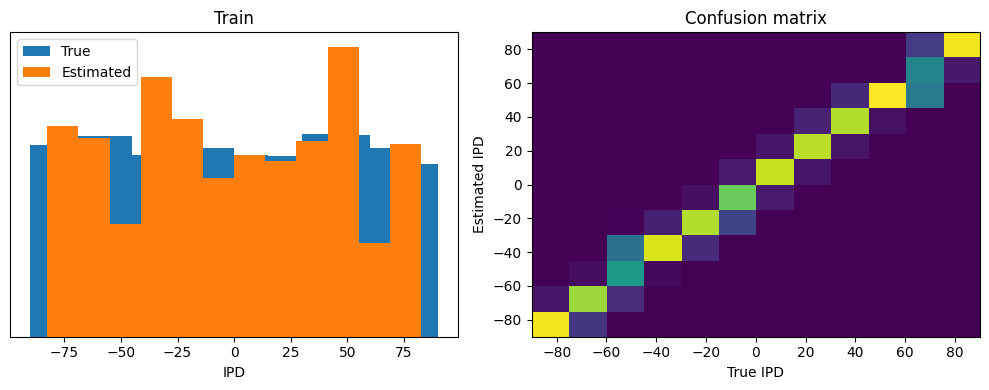

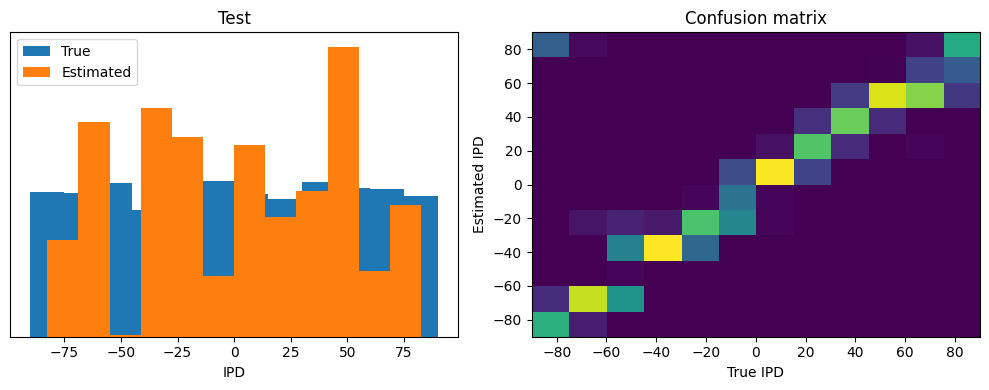

In [ ]:
# ANALYSIS

print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: snn(x, W1, W2)
results_Train = analyse(ipds, spikes, 'Train', run=run_func, plot_analysis=1)
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
results_Train = analyse(ipds_test, spikes_test, 'Test', run=run_func, plot_analysis=1)

### Now play with it
Change systematically some of the parameters and record the performance. You can do this for example by running the following code in a loop:

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.77004
Epoch 2: loss=2.57296
Epoch 3: loss=2.56450
Epoch 4: loss=2.55602
Epoch 5: loss=2.56089
Epoch 6: loss=2.58390
Epoch 7: loss=2.57072
Epoch 8: loss=2.56044
Epoch 9: loss=2.54922
Epoch 10: loss=2.55242
Chance accuracy level: 8.3%

Train classifier accuracy: 8.7%
Train absolute error: 44.7 deg

Test classifier accuracy: 8.4%
Test absolute error: 45.5 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.61462
Epoch 2: loss=1.82795
Epoch 3: loss=1.49260
Epoch 4: loss=1.28227
Epoch 5: loss=1.11968
Epoch 6: loss=1.01151
Epoch 7: loss=0.93219
Epoch 8: loss=0.86270
Epoch 9: loss=0.81091
Epoch 10: loss=0.77063
Chance accuracy level: 8.3%

Train classifier accuracy: 78.0%
Train absolute error: 5.1 deg

Test classifier accuracy: 74.0%
Test absolute error: 5.6 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.15496
Epo

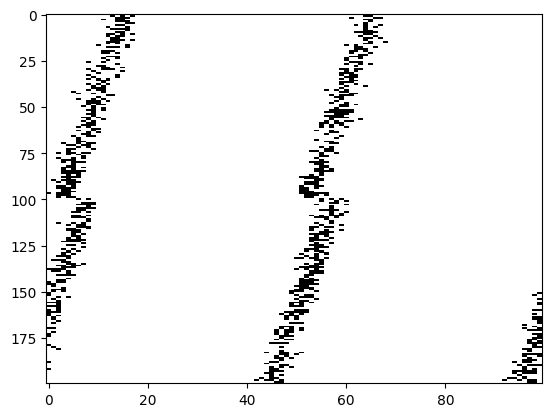

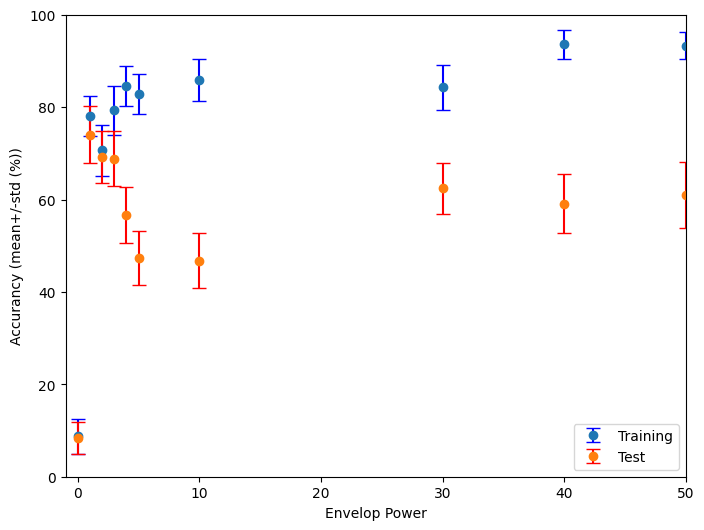

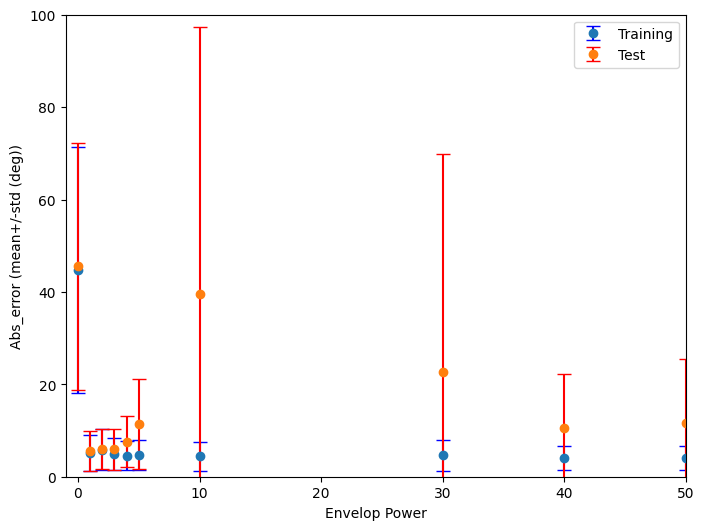

In [ ]:
plot_analysis = 0
Envelop_powers = [0, 1, 2, 3, 4, 5, 10, 30, 40, 50, 100]

Train_accuracy_mean  = []
Train_accuracy_std = []
Train_abs_error_mean = []
Train_abs_error_std = []

Test_accuracy_mean  = []
Test_accuracy_std = []
Test_abs_error_mean = []
Test_abs_error_std = []

results_Train = []
results_Test = []

#for j in range(3)
for i, envelope_power in enumerate(Envelop_powers):
    plt.imshow(spikes[0, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)

    # Training parameters
    nb_epochs = 10 # quick, it won't have converged
    lr = 0.01 # learning rate

    # Generate the training data
    ipds, spikes = random_ipd_input_signal(num_samples)

    # Initialise a weight matrices
    W1, W2 = init_weight_matrices()

    # Optimiser and loss function
    optimizer = torch.optim.Adam([W1, W2], lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for spike_batch, ipd_batch in data_generator(discretise(ipds), spikes):
            # Run network
            output = snn(spike_batch, W1, W2)
            #output = torch.abs(output)
            # Compute cross entropy loss
            m = torch.sum(output, 1) * 0.01 # Mean across time dimension
            loss = loss_fn(log_softmax_fn(m), ipd_batch)
            local_loss.append(loss.item())
            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))
        print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

    if plot_analysis:
      # Plot the loss function over time
      plt.plot(loss_hist)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.tight_layout()


    # Analyse
    print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
    run_func = lambda x: snn(x, W1, W2)
    results_Train = analyse(ipds, spikes, 'Train', run=run_func, plot_analysis=0)
    ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
    results_Test = analyse(ipds_test, spikes_test, 'Test', run=run_func, plot_analysis=0)

    Train_accuracy_mean.append(results_Train[0])
    Train_accuracy_std.append(results_Train[1])
    Train_abs_error_mean.append(results_Train[2])
    Train_abs_error_std.append(results_Train[3])

    Test_accuracy_mean.append(results_Test[0])
    Test_accuracy_std.append(results_Test[1])
    Test_abs_error_mean.append(results_Test[2])
    Test_abs_error_std.append(results_Test[3])
#
plt.figure(figsize=(8, 6))
plt.errorbar(Envelop_powers,Train_accuracy_mean, yerr=Train_accuracy_std, label='Training',fmt='o', ecolor='blue', capsize=5)
plt.errorbar(Envelop_powers,Test_accuracy_mean, yerr=Test_accuracy_std, label='Test', fmt='o', ecolor='red', capsize=5)
#plt.xscale('log')
plt.ylim([0,100])
plt.xlim([-1,50])
plt.xlabel('Envelop Power')
plt.ylabel('Accurancy (mean+/-std (%))')
plt.legend()

plt.figure(figsize=(8, 6))
plt.errorbar(Envelop_powers,Train_abs_error_mean, yerr=Train_abs_error_std, label='Training',fmt='o', ecolor='blue', capsize=5)
plt.errorbar(Envelop_powers,Test_abs_error_mean, yerr=Test_abs_error_std, label='Test', fmt='o', ecolor='red', capsize=5)
#plt.xscale('log')
plt.ylim([0,100])
plt.xlim([-1,50])
plt.xlabel('Envelop Power')
plt.ylabel('Abs_error (mean+/-std (deg))')
plt.legend()

In [ ]:
# save pipe.pkl to output data folder
!cp SoundLocalization_SNN_VB.ipynb /content/drive/MyDrive/Mini-Project_ColabNotebooks



cp: cannot stat 'SoundLocalization_SNN_VB.ipynb': No such file or directory
